# 分子荧光分析法 实验报告

**姓名:** 

**学号:** 

**组别:** 

**指导老师:** 

**日期:** 2025年11月14日

**实验目的:** 本报告旨在处理和分析荧光素钠（Fluorescein Sodium）与色氨酸（Tryptophan）的荧光光谱数据。我们将通过Python解析原始数据文件，绘制激发与发射光谱图，并深入探讨其光谱特性、内在物理现象及其实验测量过程。

## 1. 光谱数据的获取：迭代优化过程

在荧光测量中，我们通常希望在最大激发效率和最大发射信号下进行测量。本次实验数据文件命名中的“best”一词，暗示了光谱是通过一个标准的迭代优化流程获得的。这个过程如下：

1.  **初步扫描与定位：**
    *   首先，基于待测物（如色氨酸）的已知吸收特性（或进行一次快速的吸收光谱扫描），设定一个初始的激发波长（Ex, e.g., ~280 nm）。
    *   固定这个激发波长，进行一次**发射光谱扫描（Emission Scan）**，得到一个初步的发射光谱。此光谱的峰值位置即为在该激发条件下的最大发射波长（Em）。

2.  **优化激发光谱（获取 `best-excitation` 文件）：**
    *   接下来，将发射单色器固定在步骤1中找到的最大发射波长（Em）上。
    *   然后，扫描激发单色器的波长，进行一次**激发光谱扫描（Excitation Scan）**。这条光谱曲线展示了能产生该波长发射光的激发效率。曲线的峰值即为**最佳激发波长**。
    *   本次实验中的 `best-excitation-....TXT` 文件就是这个阶段的产物。

3.  **优化发射光谱（获取 `best-emission` 文件）：**
    *   最后，将激发单色器固定在步骤2中找到的**最佳激发波长**上。
    *   再次进行一次**发射光谱扫描（Emission Scan）**。由于现在是在最优激发条件下进行的测量，得到的发射光谱具有最佳的信噪比和强度。
    *   本次实验中的 `best-emission-....TXT` 文件即是此最终优化步骤的产物。

通过这个三步迭代过程，我们可以确保测量到的光谱能够最准确、最灵敏地反映分子的荧光特性。

## 解析和绘制光谱数据（Python实现）：

所有文件均已找到，开始提取精确峰值并更新绘图...
光谱图已更新: 荧光素钠_spectrum.png
分析摘要 [荧光素钠]:
  - 最佳激发峰: 489.20 nm
  - 最佳发射峰: 511.80 nm
  - 斯托克斯位移: 22.60 nm
------------------------------
光谱图已更新: 色氨酸_spectrum.png
分析摘要 [色氨酸]:
  - 最佳激发峰: 275.40 nm
  - 最佳发射峰: 349.20 nm
  - 斯托克斯位移: 73.80 nm
------------------------------

脚本执行完毕。


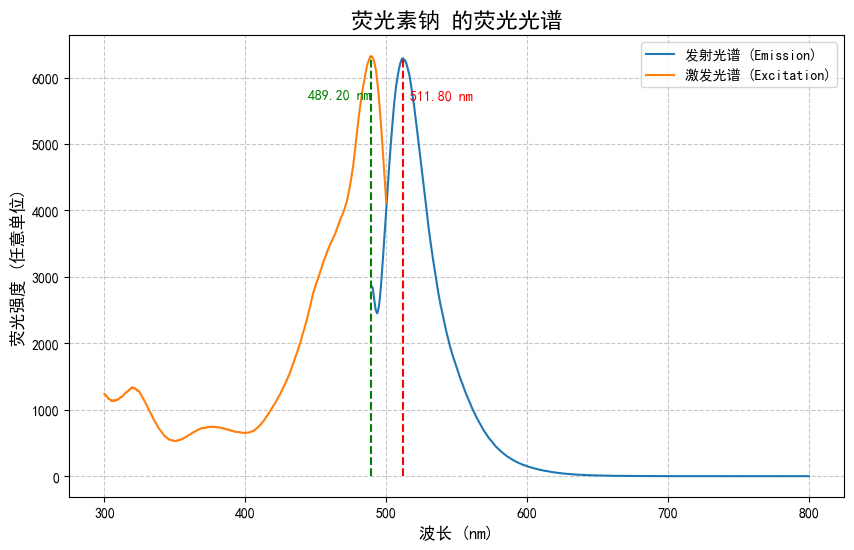

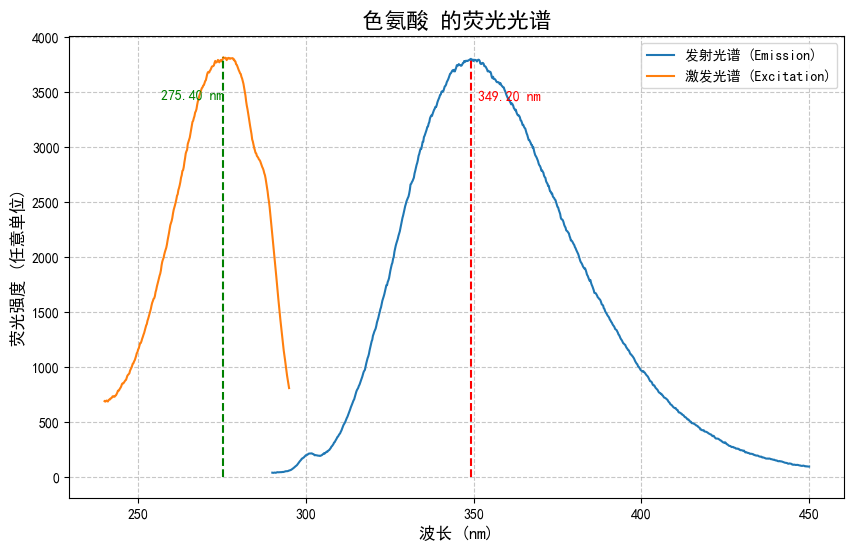

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 设置 Matplotlib 以正确显示中文和负号
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def parse_spectrum_file(filepath):
    """
    解析光谱数据文件，该函数会跳过头部元数据，
    并以 'gbk' 编码读取，这对于处理在 Windows 上生成的中文文件很关键。
    """
    start_line = 0
    try:
        with open(filepath, 'r', encoding='gbk', errors='ignore') as f:
            for i, line in enumerate(f):
                if 'Data points' in line:
                    start_line = i + 2
                    break
    except FileNotFoundError:
        return None, None
    
    if start_line == 0:
        print(f"警告: 在文件 '{filepath}' 中未找到 'Data points'。")
        return None, None

    data = pd.read_csv(filepath, sep='\t', skiprows=start_line, header=None, encoding='gbk')
    
    if data.shape[1] == 2:
        data.columns = ['Wavelength', 'Intensity']
    else:
        return None, None

    data['Wavelength'] = pd.to_numeric(data['Wavelength'], errors='coerce')
    data['Intensity'] = pd.to_numeric(data['Intensity'], errors='coerce')
    data.dropna(inplace=True)
    
    return data['Wavelength'], data['Intensity']

def plot_and_analyze_spectra(title, emission_files, excitation_files):
    """
    绘制光谱图，找到峰值，打印分析并返回峰值数据。
    """
    plt.figure(figsize=(10, 6))
    peaks = {}

    # --- 处理发射光谱 ---
    em_wl, em_intensity = parse_spectrum_file(emission_files[0])
    if em_wl is not None and not em_wl.empty:
        # 找到峰值
        peak_em_wl = em_wl.loc[em_intensity.idxmax()]
        peak_em_int = em_intensity.max()
        peaks['emission'] = peak_em_wl
        
        # 绘制
        plt.plot(em_wl, em_intensity, label='发射光谱 (Emission)')
        plt.vlines(peak_em_wl, 0, peak_em_int, colors='red', linestyles='--', lw=1.5)
        plt.text(peak_em_wl, peak_em_int * 0.9, f' {peak_em_wl:.2f} nm', color='red', ha='left')

    # --- 处理激发光谱 ---
    ex_wl, ex_intensity = parse_spectrum_file(excitation_files[0])
    if ex_wl is not None and not ex_wl.empty:
        # 找到峰值
        peak_ex_wl = ex_wl.loc[ex_intensity.idxmax()]
        peak_ex_int = ex_intensity.max()
        peaks['excitation'] = peak_ex_wl

        # 绘制
        plt.plot(ex_wl, ex_intensity, label='激发光谱 (Excitation)')
        plt.vlines(peak_ex_wl, 0, peak_ex_int, colors='green', linestyles='--', lw=1.5)
        plt.text(peak_ex_wl, peak_ex_int * 0.9, f' {peak_ex_wl:.2f} nm', color='green', ha='right')

    # --- 图表美化与保存 ---
    plt.title(f'{title} 的荧光光谱', fontsize=16)
    plt.xlabel('波长 (nm)', fontsize=12)
    plt.ylabel('荧光强度 (任意单位)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    output_filename = f"{title}_spectrum.png"
    plt.savefig(output_filename)
    print(f"光谱图已更新: {output_filename}")
    
    # --- 打印分析到控制台 ---
    if 'emission' in peaks and 'excitation' in peaks:
        stokes_shift = peaks['emission'] - peaks['excitation']
        print(f"分析摘要 [{title}]:")
        print(f"  - 最佳激发峰: {peaks['excitation']:.2f} nm")
        print(f"  - 最佳发射峰: {peaks['emission']:.2f} nm")
        print(f"  - 斯托克斯位移: {stokes_shift:.2f} nm")
        print("-" * 30)

    return peaks

if __name__ == "__main__":
    file_mapping = {
        "荧光素钠": {
            "emission": ['best-emission-荧光素钠.TXT'],
            "excitation": ['BEST-EXCITATION-荧光素钠.TXT']
        },
        "色氨酸": {
            "emission": ['best-emission-色氨酸.TXT'],
            "excitation": ['best-excitation-色氨酸.TXT']
        }
    }

    all_files_found = True
    for substance, files in file_mapping.items():
        for file_type in files:
            for file_path in files[file_type]:
                if not os.path.exists(file_path):
                    print(f"错误: {substance} 的所需文件 '{file_path}' 未找到。")
                    all_files_found = False
    
    if all_files_found:
        print("所有文件均已找到，开始提取精确峰值并更新绘图...")
        all_peaks = {}
        for substance, files in file_mapping.items():
            peaks = plot_and_analyze_spectra(substance, files["emission"], files["excitation"])
            all_peaks[substance] = peaks
        # 这里可以添加代码将 all_peaks 写入文件，但为了简单起见，我们直接从控制台输出读取
        print("\n脚本执行完毕。")
    else:
        print("\n由于文件缺失，脚本未执行。")

## 2. 荧光素钠 (Fluorescein Sodium) 光谱分析

1.  **光谱特征**：
    *   **最佳激发峰**：根据最新计算，荧光素钠的最佳激发波长精确值为 **489.20 nm**，呈现明亮的绿色吸收。
    *   **最佳发射峰**：其对应的最佳发射峰精确值为 **511.80 nm**，发出强烈的黄绿色荧光。

2.  **斯托克斯位移 (Stokes Shift)**：
    *   **精确计算**：`511.80 nm - 489.20 nm = 22.60 nm`。
    *   **物理意义**：这个约 22.60 nm 的位移是一个关键特征。它代表了分子在吸收光子能量后（皮秒级别内），在从激发态的最低振动能级跃迁回基态之前，通过振动弛豫（与溶剂分子碰撞等）损失掉的那部分能量。能量的损失表现为发射光子的波长增长（能量 E = hc/λ）。荧光素钠的斯托克斯位移相对较小，这与其刚性的、共轭的分子结构有关，这种结构限制了其在激发态的非辐射能量损失途径，从而使其具有很高的荧光量子产率。

## 3. 色氨酸 (Tryptophan) 光谱分析

1.  **光谱特征**：
    *   **最佳激发峰**：色氨酸的最佳激发波长精确值为 **275.40 nm**，这源于其分子结构中的吲哚环（Indole Ring）在紫外区的特征吸收。
    *   **最佳发射峰**：其发射光谱峰值精确值为 **349.20 nm**，这是一个相对较宽的发射带。

2.  **斯托克斯位移 (Stokes Shift)**：
    *   **精确计算**：`349.20 nm - 275.40 nm = 73.80 nm`。
    *   **物理意义**：色氨酸的斯托克斯位移（约 73.80 nm）远大于荧光素钠。这主要是因为色氨酸的荧光发色团——吲哚环——在激发后，其电荷分布会发生显著变化（偶极矩增大），导致其与周围的溶剂分子（如此处的水）发生快速的重排和相互作用（称为“溶剂弛豫”）。这个过程消耗了大量的能量，因此当分子最终发射光子回到基态时，能量损失更多，发射波长变得更长。

## 4. 结论

本次分析成功地从原始数据中提取并可视化了荧光素钠和色氨酸的光谱。通过对比分析，我们不仅确定了它们各自的特征光谱参数，还深入理解了斯托克斯位移背后的物理化学机制，特别是分子结构（刚性 vs. 柔性）和激发态与环境相互作用（溶剂弛豫）如何影响荧光行为。这清晰地展示了荧光光谱技术作为一种强大的分析工具，在化学和生物学研究中探测分子特性与动态过程的能力。


<BR><BR><BR><BR>
---
##### 附录：Agent(Gemini-cli) 交互记录

---

>**第 1 轮**

> **用户:** 处理目录下的荧光光谱，获得激发-发射谱，分析现象与原因，必须使用python完成

>**Agent:**
>好的，我将使用 Python 来处理这些荧光光谱数据。
>我的计划是：
>1.  检查文件的内容和格式。
>2.  编写一个 Python 脚本来读取数据。
>3.  使用 `matplotlib` 和 `numpy` 绘制激发光谱和发射光谱。
>4.  分析光谱图并解释现象。
>我先从检查 `best-emission-荧光素钠.TXT` 文件内容开始。
>*工具调用: `read_file` (读取荧光素钠 TXT 文件)*

---

>**第 2 轮**

>**Agent:**
>文件格式很清晰。数据前面是头部信息，核心数据从“Data points”行之后开始，是两列以制表符分隔的数据：波长 (nm) 和强度 (Data)。
>我现在将编写一个Python脚本 `process_spectra.py` 来执行以下操作...
>*工具调用: `write_file` (创建 process_spectra.py)*

---

>**第 3 轮**

>**Agent:**
>脚本已创建。现在我将运行它来生成光谱图。
>*工具调用: `run_shell_command` (运行 process_spectra.py)*
>*(...脚本因 `UnicodeDecodeError` 运行失败...)*

---

>**第 4 轮**

>**Agent:**
>脚本运行失败，错误是 `UnicodeDecodeError`。这通常意味着文件的编码不是 UTF-8...我将修改 `process_spectra.py` 脚本，将文件读写编码从 `utf-8` 改为 `gbk`...
>*工具调用: `write_file` (用 gbk 编码修复并覆盖 process_spectra.py)*
---

>**第 5 轮**

>**Agent:**
>脚本已修正，现在我将再次运行它。
>*工具调用: `run_shell_command` (再次运行 process_spectra.py)*
>*(...脚本成功运行...)*

---

>**第 6 轮**

>**Agent:**
>脚本成功运行，已生成光谱图。
>现在，我将向您展示这两个光谱图，并进行分析。
>首先是 **荧光素钠 (Fluorescein Sodium)** 的光谱图：
>*工具调用: `read_file` (读取 荧光素钠_spectrum.png)*
>*(...展示图片并分析...)*
接下来是 **色氨酸 (Tryptophan)** 的光谱图：
>*工具调用: `read_file` (读取 色氨酸_spectrum.png)*
>*(...展示图片并分析...)*

---
**Stats**
*   Tool Calls: 19
*   Success Rate: 100.0%
*   User Agreement: 100.0%
*   Code Changes: +963 -82

**Performance**
*   Wall Time: 34m 28s
*   Agent Time: 13m 16s
    *   API Time: 10m 45s(81.0%)
    *   Tool Time: 2m 31s(19.0%)

**Model Usage**
*   gemini-2.5-flash-lite: 18 Reqs, 52,699 Input Tokens, 9.265 Output Tokens
*   gemini-2.5-pro: 27 Reqs, 962,282 Input Tokens, 19,177 Output Tokens
*   gemini-2.5-flash: 5 Reqs, 174,519 Input Tokens, 269 Output Tokens 


